In [174]:
import torch
print(torch.__version__)

2.6.0+cu124


In [175]:
x = torch.tensor([[1, 2]])
y = torch.tensor([[1], [2]])

print(x.shape, y.shape)

torch.Size([1, 2]) torch.Size([2, 1])


#  Auto gradients of tensor objects


In [176]:
x = torch.tensor([[2., -1.],
                  [1., 1.]],
                 requires_grad=True)

x

tensor([[ 2., -1.],
        [ 1.,  1.]], requires_grad=True)

In [177]:
out = x.pow(2).sum()

out

tensor(7., grad_fn=<SumBackward0>)

In [178]:
# gradient can be calculated by calling backward()
# gradient = change in out for a small change input

out.backward()
x.grad

tensor([[ 4., -2.],
        [ 2.,  2.]])

# Comparison of NumPy vs Torch on GPU

In [179]:
x = torch.rand(1, 6400)
y = torch.rand(6400, 5000)

In [180]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

x, y = x.to(device), y.to(device)

In [181]:
%timeit z = (x@y)

569 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [182]:
x, y = x.cpu(), y.cpu()

In [183]:
%timeit z = (x@y)

10.4 ms ± 722 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Building a neural network using PyTorch


In [184]:
x = [[1,2], [3,4], [5,6], [7,8]]
y = [[3], [7], [11], [15]]

X = torch.tensor(x).float()
Y = torch.tensor(y).float()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X, Y = X.to(device), Y.to(device)

In [185]:
import torch.nn as nn

class MyNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.input_to_hidden_layer = nn.Linear(2, 8)
    self.hidden_layer_activation = nn.ReLU()
    self.hidden_output_to_layer = nn.Linear(8, 1)

  def forward(self, x):
    x = self.input_to_hidden_layer(x)
    x = self.hidden_layer_activation(x)
    x = self.hidden_output_to_layer(x)

    return x


In [186]:
mynet = MyNeuralNet().to(device)

mynet.input_to_hidden_layer.weight

Parameter containing:
tensor([[-0.1606,  0.4541],
        [-0.0769,  0.3312],
        [-0.5268, -0.4063],
        [ 0.4047, -0.0353],
        [ 0.6494,  0.3919],
        [ 0.4817, -0.6024],
        [-0.2356,  0.1342],
        [ 0.5205,  0.0032]], device='cuda:0', requires_grad=True)

In [187]:
for parameter in mynet.parameters():
  print(parameter)

Parameter containing:
tensor([[-0.1606,  0.4541],
        [-0.0769,  0.3312],
        [-0.5268, -0.4063],
        [ 0.4047, -0.0353],
        [ 0.6494,  0.3919],
        [ 0.4817, -0.6024],
        [-0.2356,  0.1342],
        [ 0.5205,  0.0032]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.2625, -0.4469,  0.4783, -0.6908, -0.4059,  0.5272,  0.6373,  0.0890],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.3090, -0.0014,  0.2968, -0.0861,  0.3039,  0.2542,  0.0906, -0.0573]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.1312], device='cuda:0', requires_grad=True)


In [188]:
loss = nn.MSELoss()

In [189]:
_Y = mynet(X)

loss_value = loss(Y, _Y)
loss_value

tensor(67.8054, device='cuda:0', grad_fn=<MseLossBackward0>)

In [190]:
from torch.optim import SGD

opt = SGD(mynet.parameters(), lr=0.001)

In [191]:
opt.zero_grad() # flush previous epoch's gradients
loss_value = loss(mynet(X), Y)
loss_value.backward() # Backpropagation
opt.step() # Update weights

In [192]:
loss_history = []

# 50 epochs
for _ in range(50):
  opt.zero_grad()
  loss_value = loss(mynet(X), Y)
  loss_value.backward()
  opt.step()

  loss_history.append(loss_value.item())

Text(0, 0.5, 'Loss')

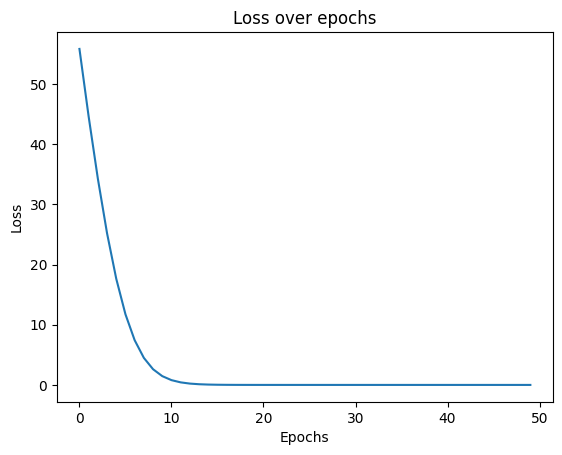

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_history)
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Specifying Batch Sizes

In [194]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.tensor(x).float()
    self.y = torch.tensor(y).float()

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [195]:
x = [[1,2],[3,4],[5,6],[7,8]]
y = [[3],[7],[11],[15]]

X = torch.tensor(x).float().to(device)
Y = torch.tensor(y).float().to(device)

In [196]:
ds = MyDataset(X, Y)

/tmp/ipython-input-2707257633.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x).float()
/tmp/ipython-input-2707257633.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y).float()


In [197]:
dl = DataLoader(ds, batch_size=2, shuffle=True)

In [198]:
for x,y in dl:
  print(x, y)

tensor([[7., 8.],
        [1., 2.]], device='cuda:0') tensor([[15.],
        [ 3.]], device='cuda:0')
tensor([[3., 4.],
        [5., 6.]], device='cuda:0') tensor([[ 7.],
        [11.]], device='cuda:0')


In [199]:
mynet = MyNeuralNet().to(device)
loss = nn.MSELoss()
opt = SGD(mynet.parameters(), lr=0.001)

In [200]:
import time

loss_history = []
start = time.time()

for _ in range(100):
  for data in dl:
    x, y = data

    opt.zero_grad()
    loss_value = loss(mynet(x), y)
    loss_value.backward()
    opt.step()

    loss_history.append(loss_value.item())

end = time.time()

print(end - start)

0.25365400314331055


# Predicting on new data

In [201]:
val_x = [[10, 11]]

val_x = torch.tensor(val_x).float().to(device)

In [202]:
mynet(val_x)

tensor([[20.8813]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Creating a custom loss function

In [203]:
# mse
def my_mse(_y, y):
  loss = (_y-y)**2
  loss = loss.mean()

  return loss

In [204]:
loss_value_std = loss(mynet(x), y)
loss_value_custom = my_mse(mynet(x), y)
print(loss_value_std, loss_value_custom)

tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>)


# Fetching intermediate layer values

In [205]:
input_to_hidden = mynet.input_to_hidden_layer(X)
activation = mynet.hidden_layer_activation(input_to_hidden)

activation

tensor([[0.0000e+00, 0.0000e+00, 4.2031e-01, 0.0000e+00, 7.8764e-01, 0.0000e+00,
         1.4280e+00, 2.0805e+00],
        [0.0000e+00, 0.0000e+00, 2.8045e-01, 0.0000e+00, 9.3061e-01, 0.0000e+00,
         2.8519e+00, 5.1680e+00],
        [0.0000e+00, 0.0000e+00, 1.4059e-01, 0.0000e+00, 1.0736e+00, 0.0000e+00,
         4.2758e+00, 8.2554e+00],
        [0.0000e+00, 0.0000e+00, 7.3501e-04, 0.0000e+00, 1.2165e+00, 0.0000e+00,
         5.6997e+00, 1.1343e+01]], device='cuda:0', grad_fn=<ReluBackward0>)